In [121]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from sklearn.feature_selection import f_classif
from sklearn import preprocessing as pp
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import shap

import warnings
warnings.filterwarnings("ignore")

RAND = 42

In [88]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [89]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока 
# просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [90]:
# заполняем пропуски в education модой
ed_mode = df.education.mode()[0]
df.education = df.education.fillna(ed_mode)

In [91]:
# разделяем признаки по типу
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'region_rating', 'work_address', 'home_address']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [92]:
# переводим в категориальный тип признаки, где классы назначены по условию (мы не знаем принцип присвоения) 
df[cat_cols] = df[cat_cols].astype(object)

In [93]:
# сразу обработаем бинарные признаки для использования в EDA
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

label_encoder = pp.LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


### EDA

### В чем состоит идея:

Мы хотим отбросить классы/признаки, которые не сильно влияют на поведение модели.

1. Смотрим на категориальные и бинарные признаки, гистограмма показывает доли класса в признаке, а также какой процент "хороших" и "плохих" заемщиков есть в каждом классе.
2. По каждому признаку и его классам делаем анализ. Гипотеза:
* если класс занимают совсем маленькую долю в признаке - он не повляет на модель;
* если доля "хороших" и "плохих" заемщиков для данного класса ровна (или имеет несущественное различие) - он не повлияет на модель.
* после кодирования категориальных признаков в числовые (get_dummies), мы выделяем классы в отдельные признаки и смотрим на их корреляцию. Признаки с положительной корреляцией (>0.6) мы сравниваем по степени их влияния на целевой признак (статистический метод ANOVA) и отбрасываем тот из них, который менее значим.
3. По результату формируем список cols_to_drop, и удалем из общего датасета выбранные нами столбцы с признаками.

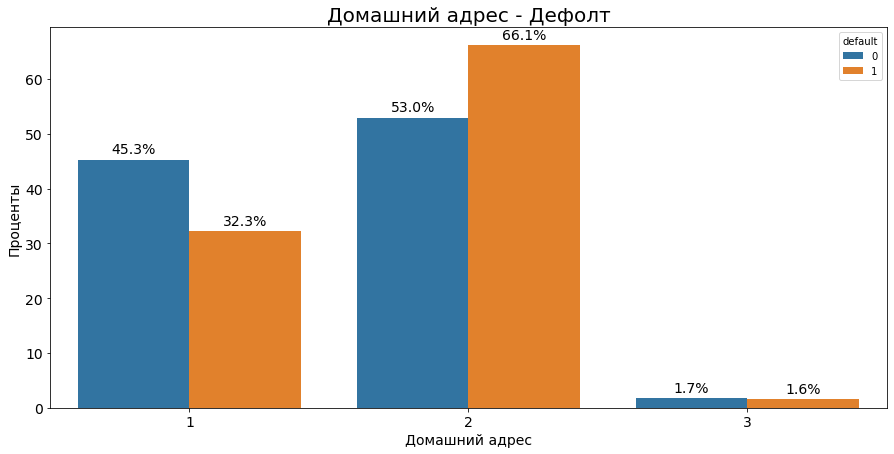

In [9]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['home_address']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('home_address'))

ax = sns.barplot(x="home_address", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Домашний адрес - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Домашний адрес', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

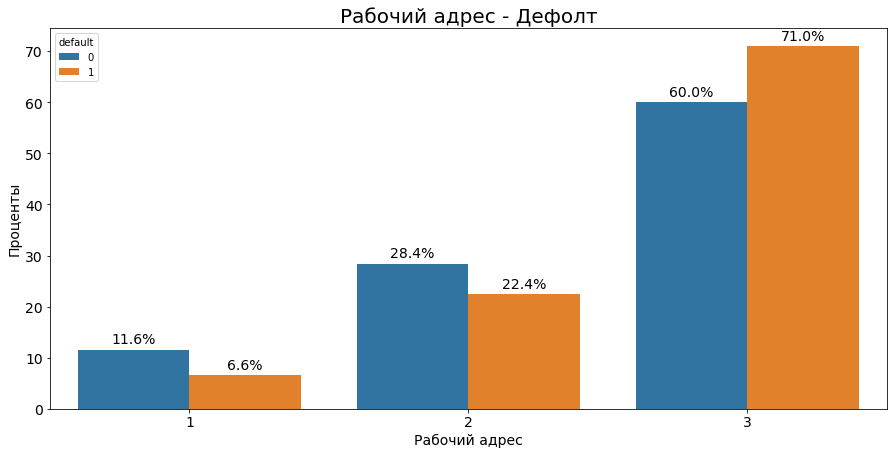

In [10]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['work_address']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('work_address'))

ax = sns.barplot(x="work_address", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Рабочий адрес - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Рабочий адрес', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

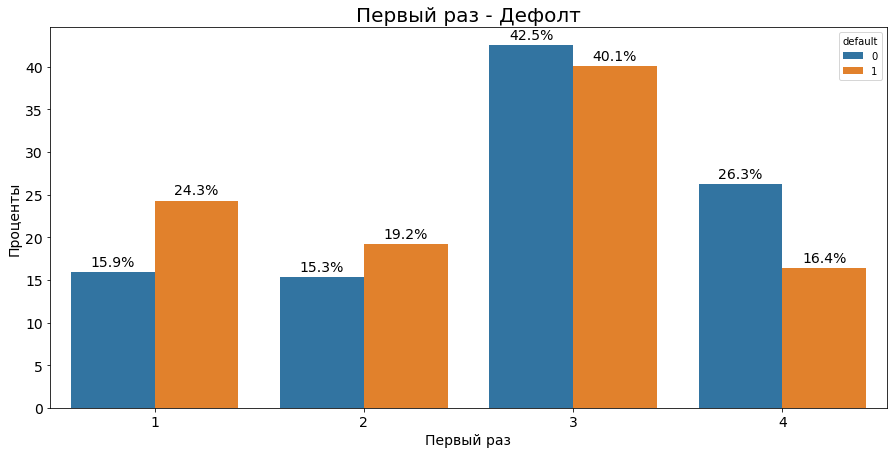

In [11]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['first_time']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('first_time'))

ax = sns.barplot(x="first_time", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Первый раз - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Первый раз', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

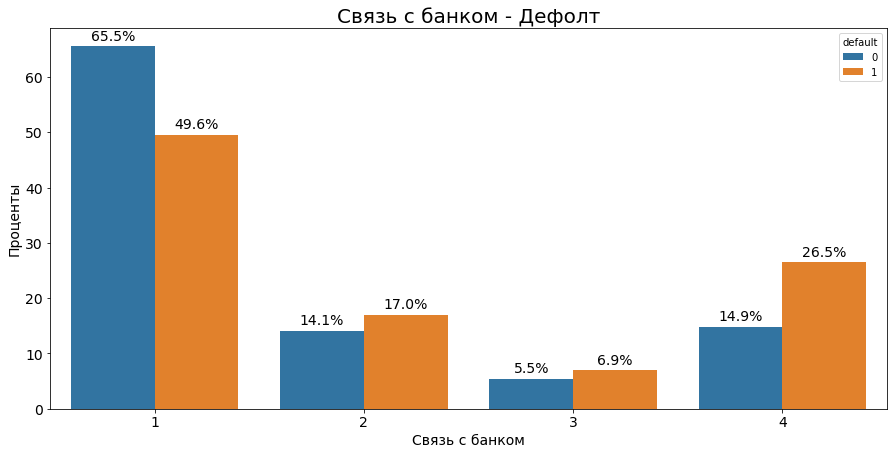

In [12]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['sna']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('sna'))

ax = sns.barplot(x="sna", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Связь с банком - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Связь с банком', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

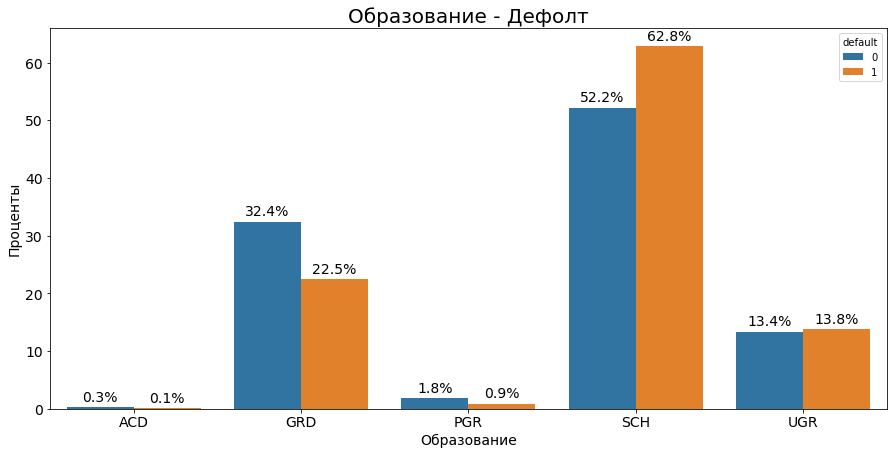

In [13]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Образование - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Образование', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

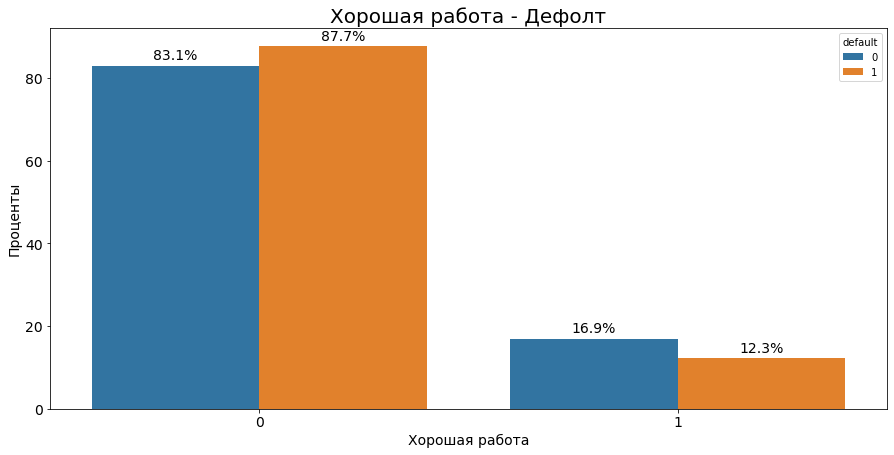

In [15]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['good_work']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('good_work'))

ax = sns.barplot(x="good_work", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Хорошая работа - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Хорошая работа', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [16]:
print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


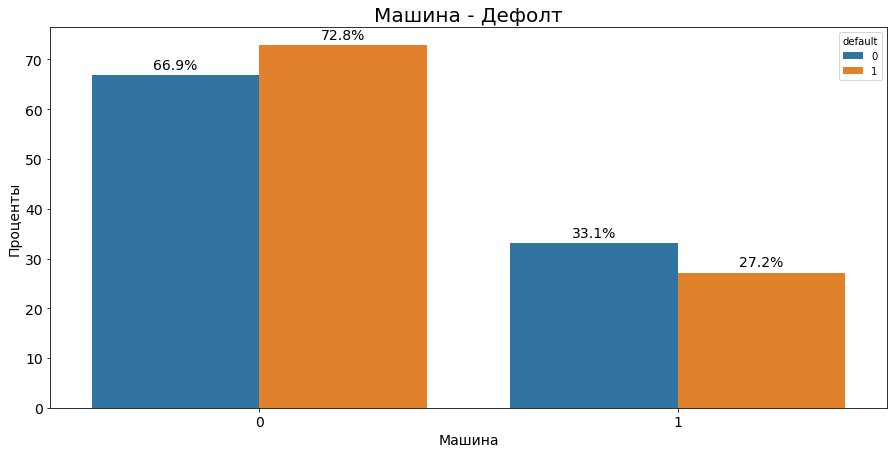

In [17]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['car']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('car'))

ax = sns.barplot(x="car", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Машина - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Машина', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

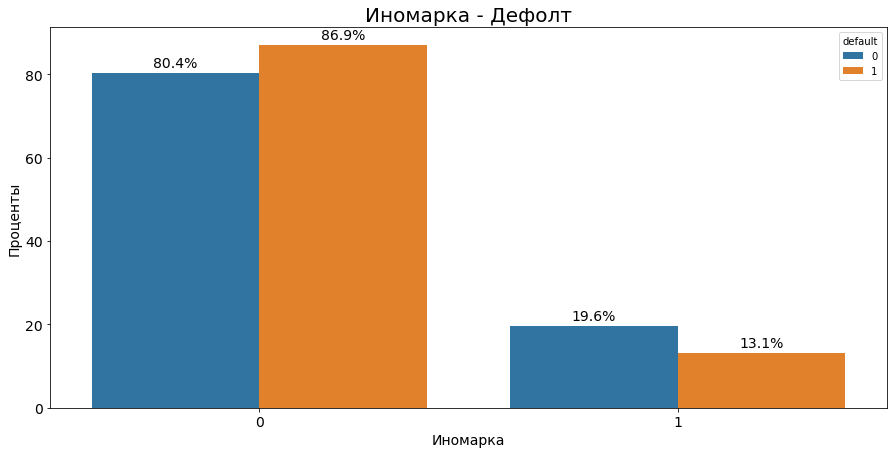

In [18]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['car_type']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('car_type'))

ax = sns.barplot(x="car_type", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Иномарка - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Иномарка', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

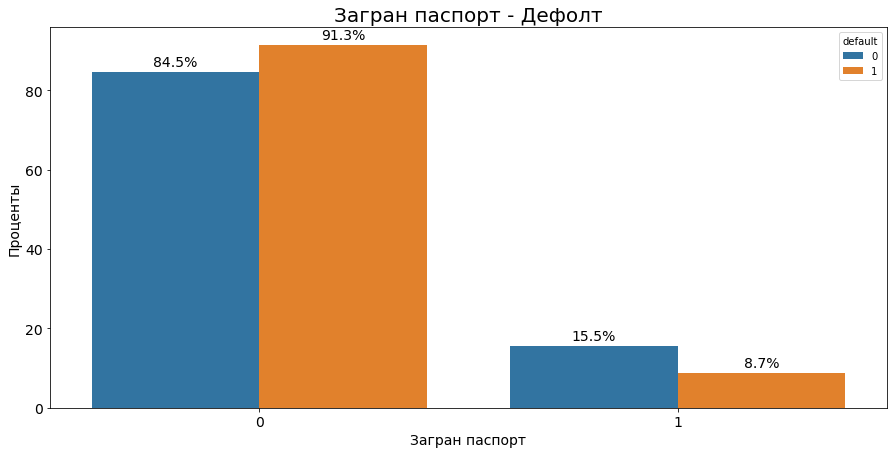

In [19]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['foreign_passport']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('foreign_passport'))

ax = sns.barplot(x="foreign_passport", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Загран паспорт - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Загран паспорт', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

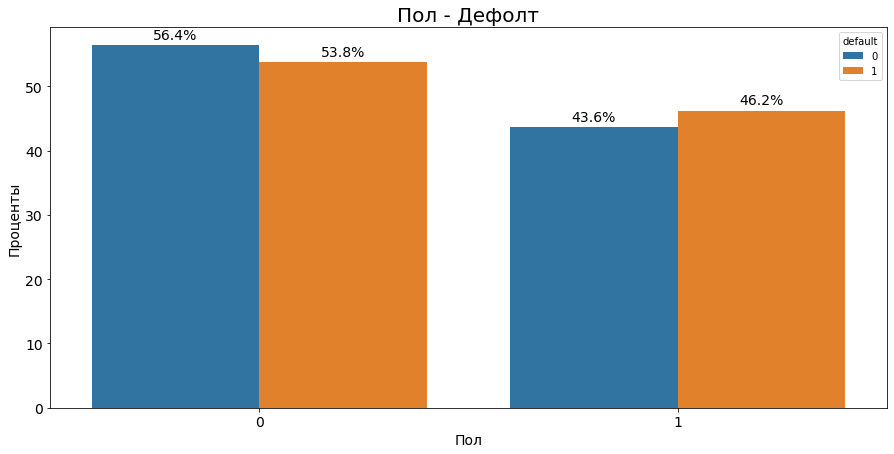

In [20]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['sex']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('sex'))

ax = sns.barplot(x="sex", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Пол - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Пол', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

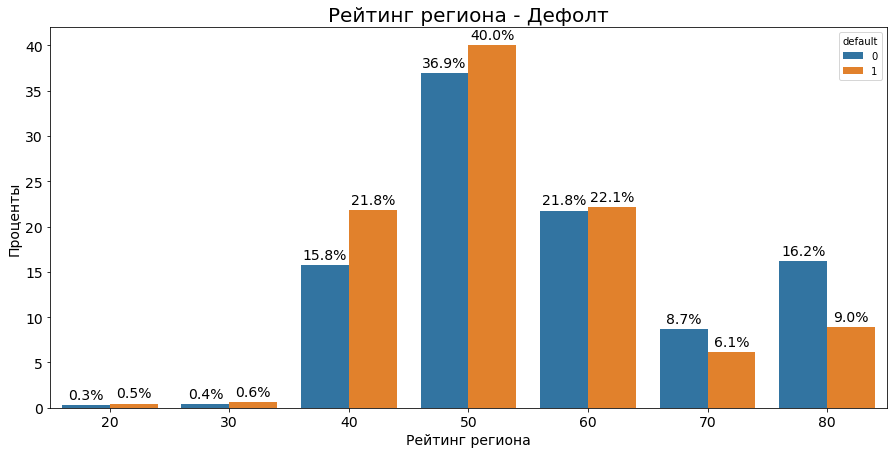

In [51]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['region_rating']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('region_rating'))

ax = sns.barplot(x="region_rating", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Рейтинг региона - Дефолт', fontsize=20)
plt.ylabel('Проценты', fontsize=14)
plt.xlabel('Рейтинг региона', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [94]:
# раскодируем категориальные признаки
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
df = pd.get_dummies(df, columns=cat_cols,
                          drop_first=False).drop(['client_id', 'app_date'], axis=1)

In [95]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'income', 'foreign_passport', 'sample',
       'default', 'education_ACD', 'education_GRD', 'education_PGR',
       'education_SCH', 'education_UGR', 'first_time_1', 'first_time_2',
       'first_time_3', 'first_time_4', 'sna_1', 'sna_2', 'sna_3', 'sna_4',
       'work_address_1', 'work_address_2', 'work_address_3', 'home_address_1',
       'home_address_2', 'home_address_3', 'region_rating_20',
       'region_rating_30', 'region_rating_40', 'region_rating_50',
       'region_rating_60', 'region_rating_70', 'region_rating_80'],
      dtype='object')

### Корреляции НЕ числовых признаков

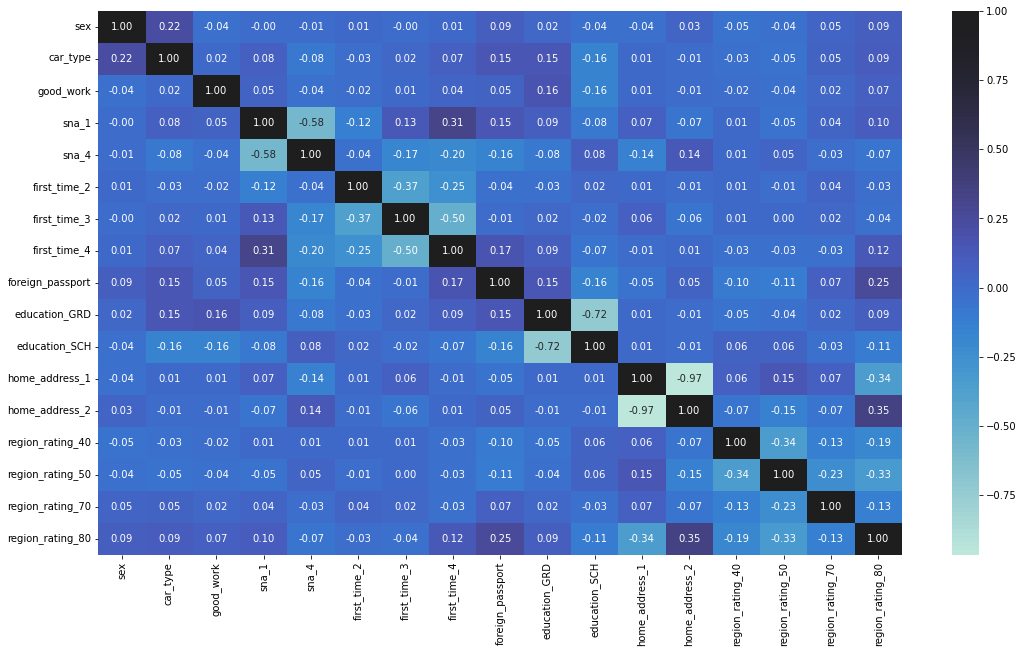

In [96]:
non_num_cols = ['sex', 'car_type', 'good_work',
                'sna_1', 'sna_4', 'first_time_2', 
                'first_time_3', 'first_time_4', 'foreign_passport',
                'education_GRD', 'education_SCH', 
                'home_address_1', 'home_address_2', 'region_rating_40', 
                'region_rating_50', 'region_rating_70', 'region_rating_80']

plt.figure(figsize=(18, 10))

sns.heatmap(df[non_num_cols].corr(method='spearman'), annot=True, fmt=".2f", center=1);

<AxesSubplot:>

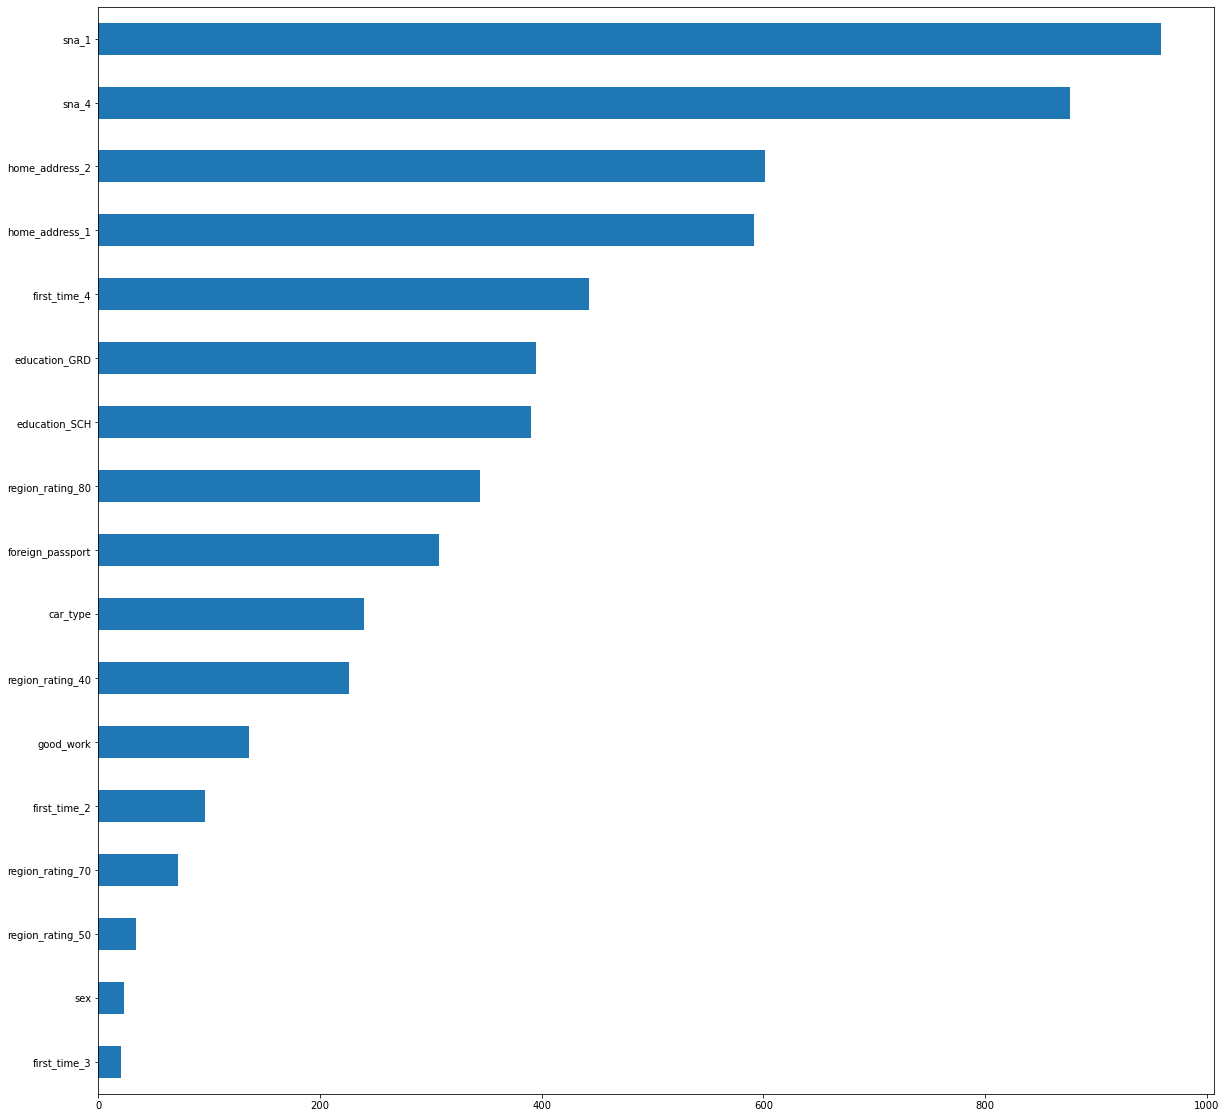

In [97]:
# проводим анализ значимости признаков (метод ANOVA)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20,20)

imp_num = pd.Series(f_classif(df[non_num_cols], df['default'])[0], index = non_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Выбросы

In [98]:
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

In [99]:
df.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
28        5
25        5
27        5
26        4
32        4
29        3
33        2
40        2
47        1
34        1
36        1
53        1
45        1
41        1
46        1
Name: bki_request_cnt, dtype: int64

Можно попробовать RobustScaller. так ка кон лучше работает с выбросами

### Нормализация

In [100]:
# нормализуем числовые признаки в исходном датасете методом логарифмирования
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)

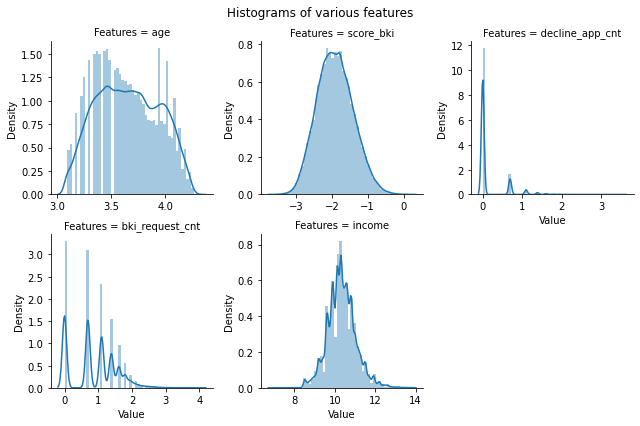

In [101]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']

numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  float64
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   income            110148 non-null  float64
 9   foreign_passport  110148 non-null  int64  
 10  sample            110148 non-null  int64  
 11  default           110148 non-null  int64  
 12  education_ACD     110148 non-null  uint8  
 13  education_GRD     110148 non-null  uint8  
 14  education_PGR     110148 non-null  uint8  
 15  education_SCH     110148 non-null  uint8  
 16  education_UGR     11

In [1]:
cols_to_drop =['home_address_3', 'sna_2', 'sna_3', 'education_ACD', 'education_PGR', 'education_UGR', 
               'region_rating_20', 'region_rating_30', 'region_rating_30', 'work_address_3', 'work_address_2',
               'work_address_1', 'car', 'first_time_1']

In [105]:
# создаем финальный датасет для последующего моделирования
df = df.drop(cols_to_drop, axis=1)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  float64
 2   car_type          110148 non-null  int64  
 3   decline_app_cnt   110148 non-null  float64
 4   good_work         110148 non-null  int64  
 5   score_bki         110148 non-null  float64
 6   bki_request_cnt   110148 non-null  float64
 7   income            110148 non-null  float64
 8   foreign_passport  110148 non-null  int64  
 9   sample            110148 non-null  int64  
 10  default           110148 non-null  int64  
 11  education_GRD     110148 non-null  uint8  
 12  education_SCH     110148 non-null  uint8  
 13  first_time_2      110148 non-null  uint8  
 14  first_time_3      110148 non-null  uint8  
 15  first_time_4      110148 non-null  uint8  
 16  sna_1             11

### Моделирование

In [151]:
# выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'default'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # наш таргет

In [152]:
# делим датасет на обучающий и валидационный
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND)

In [153]:
scaler = RobustScaler()

In [154]:
X_train_rs = scaler.fit_transform(X_train)

In [155]:
X_test_rs = scaler.transform(X_test)

In [156]:
lr = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
lr.fit(X_train_rs, y_train)

y_pred = lr.predict(X_test_rs)
y_score = lr.predict_proba(X_test_rs)[:,1]

In [157]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7410539206506219
precision: 0.22355253752680487
recall: 0.6847290640394089
f1: 0.3370604876734474
logloss: 11.515500873319082


In [158]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
metrics

,Baseline_LR
roc-auc,0.741054
precision,0.223553
recall,0.684729
f1,0.337060
logloss,11.515501


In [159]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test,y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760



In [160]:
random_seed = RAND
C = np.logspace(-2, 1, 10)
iter_ = 100
epsilon_stop = 1e-3
 
param_grid = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'],
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     #'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'],
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

lr = LogisticRegression(class_weight = 'balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_cv = GridSearchCV(lr, param_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

# производим обучение по сетке
grid_cv.fit(X_train_rs, y_train)

In [162]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7285147578619997
{'C': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'saga', 'tol': 0.001}


In [163]:
best_params = {'C': 1.0, 
               'max_iter': 100, 
               'penalty': 'none',
               'multi_class': 'ovr',
               'solver': 'saga',
               'tol': 0.001}

In [164]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train_rs, y_train)

y_pred_gr = lr_gr.predict(X_test_rs)
y_score_gr = lr_gr.predict_proba(X_test_rs)[:,1]

In [165]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7410158735237323
precision: 0.22363246335359313
recall: 0.6847290640394089
f1: 0.33715132731437814
logloss: 11.510820713970526


In [166]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]
metrics

,Baseline_LR,Grid_LR
roc-auc,0.741054,0.741016
precision,0.223553,0.223632
recall,0.684729,0.684729
f1,0.337060,0.337151
logloss,11.515501,11.510821


### Тестируем другой регулятор (lr_gr_1)

In [168]:
 parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

# производим обучение по сетке
grid_cv.fit(X_train_rs, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.4s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l2, solver=sag; total time=   0.6s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, pe

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]),
                         'l1_ratio': [0.25, 0.5, 0.75],
                         'max_iter': array([100, 200, 300, 400]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='roc_auc', verbose=2)

In [169]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7278547681656747
{'C': 750.25, 'l1_ratio': 0.5, 'max_iter': 400, 'penalty': 'l2', 'solver': 'sag'}


In [179]:
best_params = {'C': 750.25, 
               'l1_ratio': 0.25,
               'max_iter': 400, 
               'penalty': 'l2',
               'multi_class': 'auto',
               'solver': 'sag',
               'tol': 0.001}

In [180]:
lr_gr_1 = LogisticRegression(**best_params, class_weight='balanced')
lr_gr_1.fit(X_train_rs, y_train)

y_pred_gr_1 = lr_gr_1.predict(X_test_rs)
y_score_gr_1 = lr_gr_1.predict_proba(X_test_rs)[:,1]

In [181]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr_1))
print('precision:', precision_score(y_test, y_pred_gr_1))
print('recall:', recall_score(y_test, y_pred_gr_1))
print('f1:', f1_score(y_test, y_pred_gr_1))
print('logloss:', log_loss(y_test, y_pred_gr_1))

roc-auc: 0.7410148154834962
precision: 0.2240329512893983
recall: 0.6847290640394089
f1: 0.3376062609634327
logloss: 11.487419917227749


In [182]:
metrics['Grid_LR_1'] = [roc_auc_score(y_test, y_score_gr_1),
                      precision_score(y_test, y_pred_gr_1),
                      recall_score(y_test, y_pred_gr_1),
                      f1_score(y_test, y_pred_gr_1),
                      log_loss(y_test, y_pred_gr_1)]
metrics

,Baseline_LR,Grid_LR,Grid_LR_1
roc-auc,0.741054,0.741016,0.741015
precision,0.223553,0.223632,0.224033
recall,0.684729,0.684729,0.684729
f1,0.337060,0.337151,0.337606
logloss,11.515501,11.510821,11.487420
